# Parameters Inference

The goal of this notebook is to show the user how to use the gradient calculated through autodiff to do parameters inference. To do so we reproduce the same example as in custom models.

$y_t = \epsilon_t \exp\big(\frac{h_t}{2}\big), \quad \epsilon_t \sim \mathcal{N}(0,1)$

$h_{t+1} = \mu(1 − \phi) + \phi h_t + \sigma_\eta \eta_t, \quad \eta_t \sim \mathcal{N}(0,1)$, $t = 1,..., T,$

$h_0 \sim \mathcal{N}\big(0, \frac{\sigma^2_η}{(1 − \phi^2)}\big)$

## Imports

First thing first: let's import what we'll be needing.

In [1]:
import sys
sys.path.append("../..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# tensorflow imports
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [4]:
# filterflow model imports
from filterflow import SMC, State
from filterflow.observation import ObservationModelBase
from filterflow.proposal import BootstrapProposalModel
from filterflow.transition import RandomWalkModel, TransitionModelBase

### The Model

The transition model can be encoded by adding a location to the normal distribution:

In [5]:
dx = 1
mu = tf.Variable(tf.constant(0.), trainable=True)
phi = tf.Variable(tf.constant(0.5), trainable=True)
sigma_x = tf.Variable(0.5 * tf.ones(dx), trainable=True)

noise_rv = tfd.MultivariateNormalDiag(mu*(1-phi), sigma_x)
transition_matrix = phi * tf.eye(dx)

transition_model = RandomWalkModel(transition_matrix, noise_rv)

The Observation model however is a bit more complicated and you'll have to code it yourself, hopefully, this is done in a few lines of code:

ObservationModelBase is a base class that only has a loglikelihood method

In [6]:
class StochVolObservationModel(ObservationModelBase):
    def __init__(self, observation_error, name='StochVolObservationModel'):
        super(StochVolObservationModel, self).__init__(name=name)
        self._observation_error = observation_error
        
    def _get_distribution(self, exp_particles):
        scale = tfp.bijectors.Scale(exp_particles)
        return tfd.TransformedDistribution(self._observation_error, scale)
        
    def loglikelihood(self, state, observation):
        # To simplify our work, let's simply use the tfp.bijectors utilities:
        particles = state.particles
        exp_particles = tf.exp(state.particles / 2.)
        dist = self._get_distribution(exp_particles)
        likelihoods = dist.log_prob(observation)
        return likelihoods

In [7]:
dy = 1
sigma_y = tf.Variable(0.5 * tf.ones(dx))

error_rv = tfd.MultivariateNormalDiag(scale_diag=sigma_y)

observation_model = StochVolObservationModel(error_rv)

### Let's test it

First get some data:

In [8]:
import quandl

In [9]:
API_KEY = "CnKBgy39JqPW7ejJJfV9"

You can visit https://www.quandl.com/ to get your own API key

In [10]:
start_date = "2019-09-01"
end_date = "2020-01-01"

In [11]:
quandl.ApiConfig.api_key = API_KEY
d = quandl.get("ECB/EURUSD", start_date=start_date, end_date=end_date)

In [12]:
d.head()

,Value
Date,
2019-09-02,1.0968
2019-09-03,1.0937
2019-09-04,1.1018
2019-09-05,1.1058
2019-09-06,1.1027


Now take the log-returns:

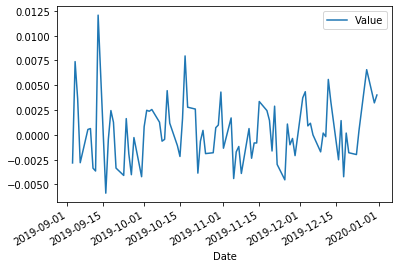

In [13]:
logreturns = np.log(d).diff().dropna()
logreturns.plot()

In [14]:
y = 100 * logreturns.values.astype(np.float32)

### We can now build our filter:

In [15]:
variables = [mu, phi, sigma_x, sigma_y]

In [16]:
# filterflow resampling imports
from filterflow.resampling import NeffCriterion, RegularisedTransform, SystematicResampler, PartiallyCorrectedRegularizedTransform

In [17]:
proposal_model = BootstrapProposalModel(transition_model)
criterion = NeffCriterion(0.5, is_relative=True)
intermediate_resampler = RegularisedTransform(0.5, scaling=0.95, max_iter=500, convergence_threshold=1e-5)
# resampler = PartiallyCorrectedRegularizedTransform(intermediate_resampler)
resampler = RegularisedTransform(0.5, scaling=0.95, max_iter=500, convergence_threshold=1e-3)
# resampler = SystematicResampler()
smc = SMC(observation_model, transition_model, proposal_model, criterion, resampler)

In [18]:
batch_size = 1
n_particles = 5
initial_state = State(np.random.normal(mu, sigma_x ** 2 / (1 - phi ** 2), [batch_size, n_particles, dx]).astype(np.float32))
observations_dataset = tf.data.Dataset.from_tensor_slices(y)

In [19]:
initial_state.particles

array([[[-0.1590729 ],
        [-0.22568174],
        [ 0.4255671 ],
        [ 0.07910511],
        [-0.19535446]]], dtype=float32)

Now what we are interested in is the log-likelihood of the model and its gradient, not the full history:

In [20]:
states = smc(initial_state, observations_dataset, n_observations=len(y), return_final=False, seed=555)

In [21]:
with tf.GradientTape(watch_accessed_variables=True) as tape:
    tape.watch(variables)
    final_state = smc(initial_state, observations_dataset, n_observations=len(y), return_final=True, seed=555)
print(tape.gradient(final_state.log_likelihoods, variables))

[None, None, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-3.1100068], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-94.74275], dtype=float32)>]


Why do we get Nones? This is a common ptfall that come from the fact that *some* operation is done outside the tape scope, that is $\mu (1-\phi)$

We need to write the model in a more customized way (or reparametrize)

In [22]:
import attr # This make updating the State easier 

class SVTransitionModel(TransitionModelBase):
    def __init__(self, mu, phi, noise_rv):
        self._mu = mu
        self._phi = phi
        self._noise_rv = noise_rv
        
    def loglikelihood(self, prior_state, proposed_state, inputs):
        prior_particles = prior_state.particles
        loc = self._phi * prior_particles + self._mu * (1 - self._phi)
        diff = proposed_state.particles - loc
        return self._noise_rv.log_prob(diff)
        
    def sample(self, state, inputs, seed):
        batch_size, n_particles = state.batch_size, state.n_particles
        particles = state.particles
        loc = self._phi * particles + self._mu * (1 - self._phi)
        new_particles = loc + self._noise_rv.sample((batch_size, n_particles), seed=seed)
        return new_particles

In [23]:
noise_rv = tfd.MultivariateNormalDiag(scale_diag=sigma_x)
transition_model = SVTransitionModel(mu, phi, noise_rv)
proposal_model = BootstrapProposalModel(transition_model)
smc = SMC(observation_model, transition_model, proposal_model, criterion, resampler)

In [24]:
with tf.GradientTape(watch_accessed_variables=True) as tape:
    tape.watch(variables)
    final_state = smc(initial_state, observations_dataset, n_observations=len(y), return_final=True, seed=555)
print(tape.gradient(final_state.log_likelihoods, variables))

[<tf.Tensor: shape=(), dtype=float32, numpy=-23.53124>, <tf.Tensor: shape=(), dtype=float32, numpy=3.6438472>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-3.1100068], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-94.74275], dtype=float32)>]


In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=1e-2)

@tf.function
def optimization(n_iter, change_seed):
    # change_seed = True is ELBO, otherwise it's a MLE
    variables = [mu, phi, sigma_x, sigma_y]
    res = tf.constant(0.)
    for i in tf.range(n_iter):
        with tf.GradientTape() as tape:
            tape.watch(variables)
            if change_seed:
                seed = i
            else:
                seed = 0
            final_state = smc(initial_state, observations_dataset, n_observations=len(y), return_final=True, seed=seed)
            res = -tf.reduce_mean(final_state.log_likelihoods)
        grads = tape.gradient(res, variables)
        optimizer.apply_gradients(zip(grads, variables))
        tf.print("\rStep:", i+1, "/", n_iter, ", loss:", res, 
                 ", sigma_x:", sigma_x[0], ", sigma_y:", sigma_y[0],
                 ", mu:", mu, ", phi:", phi,
                 end="")
    return res

In [ ]:
optimization(100, True)

Step: 70 / 100 , loss: 19.1054173 , sigma_x: 0.0293514561 , sigma_y: 0.673717856 , mu: -1.76300168 , phi: 0.916084349427

Now that we have our gradient, we can simply go on and use it to learn the parameters